In [1]:
#!curl -s https://course.fast.ai/setup/colab | bash

%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision import *
from fastai import *


In [3]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fastai-v3/'


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [4]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [19]:
path=Path('/content/gdrive/My Drive/fastai-v3/camvid')

In [20]:
path

PosixPath('/content/gdrive/My Drive/fastai-v3/camvid')

In [21]:
path = untar_data(URLs.CAMVID,dest = path)

In [22]:
path.ls()

[PosixPath('/content/gdrive/My Drive/fastai-v3/camvid/camvid/codes.txt'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/camvid/camvid/images'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/camvid/camvid/valid.txt'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/camvid/camvid/labels')]

In [23]:
path_img = path/'images'
path_lbl = path/'labels'


In [24]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/content/gdrive/My Drive/fastai-v3/camvid/camvid/labels/0001TP_009690_P.png'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/camvid/camvid/labels/0016E5_08073_P.png'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/camvid/camvid/labels/0016E5_04470_P.png')]

In [25]:
fnames = get_image_files(path_img)

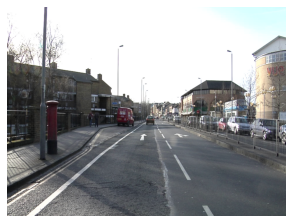

In [26]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [27]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

In [28]:
??open_mask

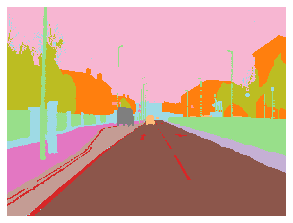

In [29]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5),alpha=1)

In [30]:
mask.shape

torch.Size([1, 720, 960])

In [31]:
mask.data[0]

tensor([[21, 21, 21,  ..., 21, 21, 21],
        [21, 21, 21,  ..., 21, 21, 21],
        [21, 21, 21,  ..., 21, 21, 21],
        ...,
        [18, 18, 18,  ..., 17, 17, 17],
        [18, 18, 18,  ..., 17, 17, 17],
        [18, 18, 18,  ..., 17, 17, 17]])

In [32]:
codes = np.loadtxt(path/'codes.txt',dtype=str);codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

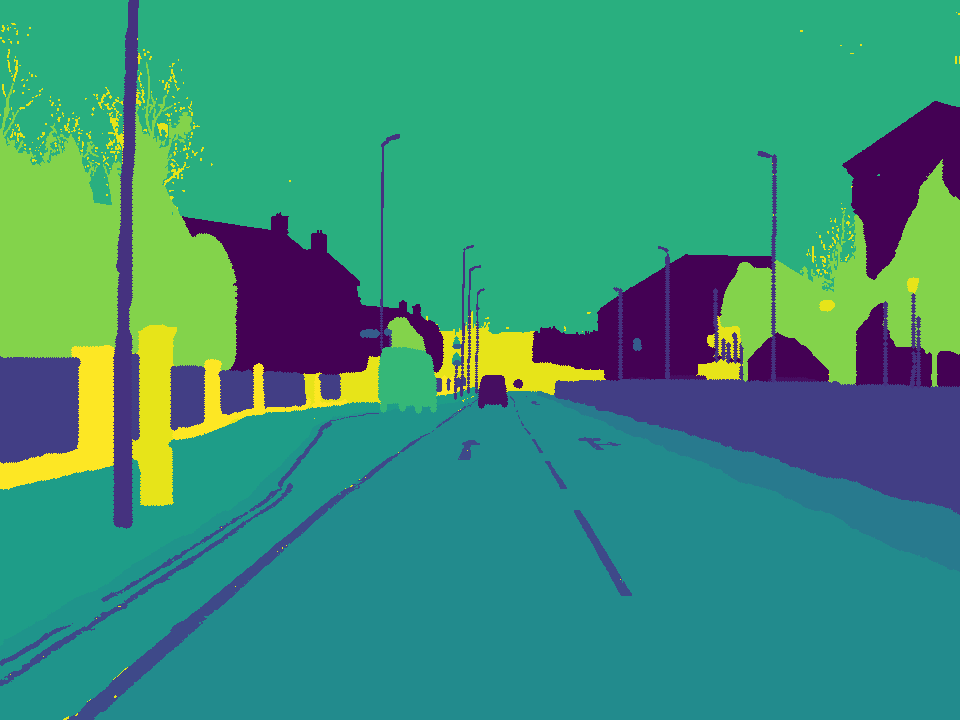

In [34]:
mask

In [35]:
src_size = np.array(mask.shape[1:]);
src_size

array([720, 960])

In [36]:
size = src_size//2

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free} MB of GPU RAM free")

using bs=8, have 16270 MB of GPU RAM free


In [43]:
codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

In [37]:
src = (SegmentationItemList.from_folder(path_img)
      .split_by_fname_file(path/'valid.txt')
      .label_from_func(get_y_fn, classes = codes)
      )

In [38]:
data = (src.transform(get_transforms(),size=size,tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

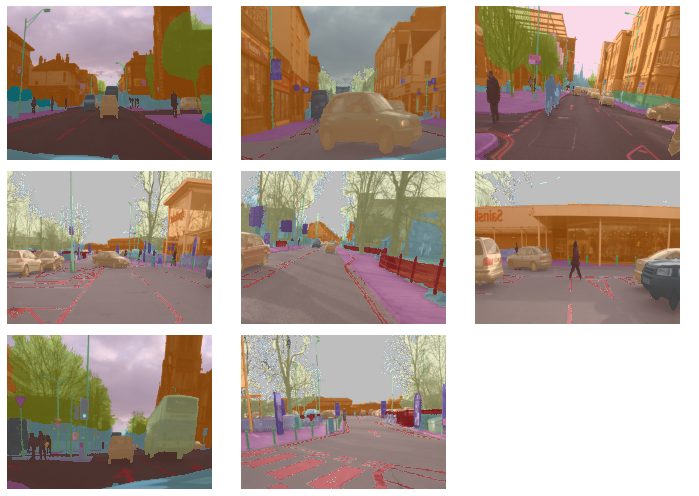

In [39]:
data.show_batch(3,figsize=(10,7))

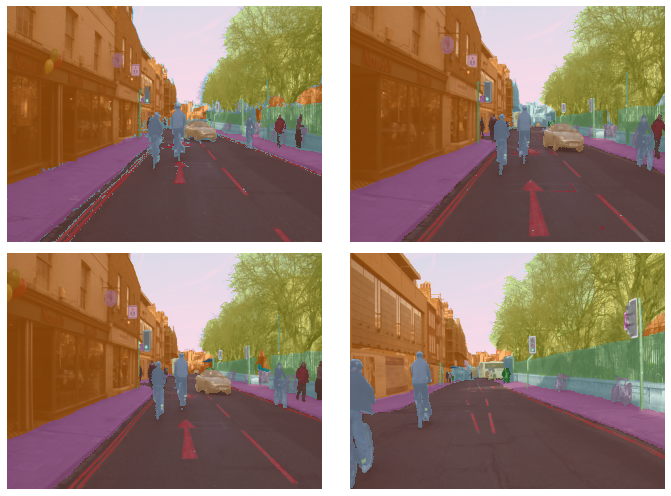

In [40]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

In [41]:
name2id = {n:i for i,n in enumerate(codes)}

In [42]:
void_code = name2id['Void']
# We hae to remove this void_code while calculating the accuracy

In [45]:
name2id

{'Animal': 0,
 'Archway': 1,
 'Bicyclist': 2,
 'Bridge': 3,
 'Building': 4,
 'Car': 5,
 'CartLuggagePram': 6,
 'Child': 7,
 'Column_Pole': 8,
 'Fence': 9,
 'LaneMkgsDriv': 10,
 'LaneMkgsNonDriv': 11,
 'Misc_Text': 12,
 'MotorcycleScooter': 13,
 'OtherMoving': 14,
 'ParkingBlock': 15,
 'Pedestrian': 16,
 'Road': 17,
 'RoadShoulder': 18,
 'SUVPickupTruck': 22,
 'Sidewalk': 19,
 'SignSymbol': 20,
 'Sky': 21,
 'TrafficCone': 23,
 'TrafficLight': 24,
 'Train': 25,
 'Tree': 26,
 'Truck_Bus': 27,
 'Tunnel': 28,
 'VegetationMisc': 29,
 'Void': 30,
 'Wall': 31}

In [46]:
def acc_camvid(input, target):
  target=target.squeeze(1)
  mask = target!=void_code
  return (input.argmax(dim=1)[mask] == target[mask]).float().mean()



In [47]:
metrics = acc_camvid

In [48]:
wd = 1e-2

In [49]:
learn = unet_learner(data,arch=models.resnet34,metrics=metrics)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [50]:
learn.lr_find()

epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


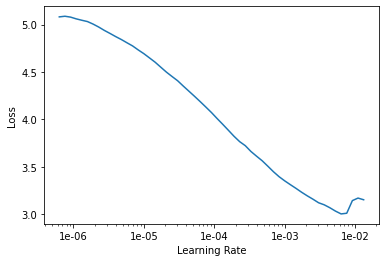

In [51]:
learn.recorder.plot()

In [52]:
learn.fit_one_cycle(10,slice(1e-5,1e-3))

epoch,train_loss,valid_loss,acc_camvid,time
0,1.409688,0.832761,0.797358,00:57
1,0.899898,0.656750,0.836211,00:55
2,0.753879,0.665032,0.811018,00:56
3,0.629979,0.457389,0.875128,00:55
4,0.543442,0.402484,0.883740,00:55
5,0.476043,0.361517,0.901193,00:55
6,0.436484,0.344300,0.906997,00:54
7,0.388602,0.314627,0.909422,00:55
8,0.357964,0.302105,0.913154,00:55
9,0.333423,0.298822,0.913755,00:55


In [53]:
learn.save('camvid-stage1-34')

In [54]:
learn.unfreeze()

In [55]:
learn.lr_find()

epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


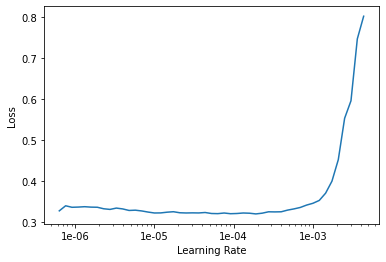

In [56]:
learn.recorder.plot()

In [57]:
learn.fit_one_cycle(10,slice(1e-6,1e-4))

epoch,train_loss,valid_loss,acc_camvid,time
0,0.320198,0.302072,0.911514,00:53
1,0.320745,0.303384,0.911196,00:53
2,0.321821,0.308488,0.911542,00:53
3,0.313692,0.304600,0.910992,00:53
4,0.297720,0.293905,0.915290,00:53
5,0.282714,0.296511,0.913702,00:53
6,0.274494,0.294369,0.916195,00:54
7,0.270584,0.292249,0.916030,00:54
8,0.259174,0.288150,0.917692,00:54
9,0.262388,0.285525,0.918036,00:54


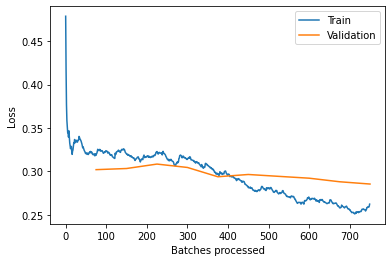

In [58]:
learn.recorder.plot_losses()

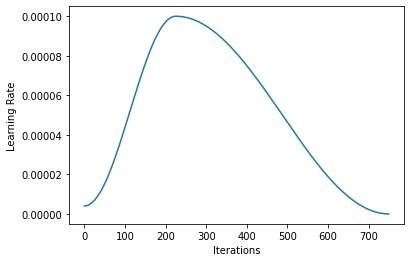

In [59]:
learn.recorder.plot_lr()

In [60]:
learn.save('camvid-stage2-34')

## Now we will increase the size of images - double it and retrain the model on the previously saved weights.


In [61]:
size = src_size

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8 
else:           bs=4
print(f"using bs={bs}, have {free} MB of GPU RAM free")

using bs=8, have 8829 MB of GPU RAM free


In [62]:
torch.cuda.empty_cache()

In [63]:
learn.destroy()

this Learner object self-destroyed - it still exists, but no longer usable


In [64]:
data = (src.transform(get_transforms(),size=size,tfm_y=True)
        .databunch(bs=4)
        .normalize(imagenet_stats))

In [65]:
learn = unet_learner(data, models.resnet34, metrics=metrics).to_fp16()

In [66]:
learn.load('camvid-stage2-34')

Learner(data=ImageDataBunch;

Train: LabelList (600 items)
x: SegmentationItemList
Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960)
y: SegmentationLabelList
ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960)
Path: /content/gdrive/My Drive/fastai-v3/camvid/camvid/images;

Valid: LabelList (101 items)
x: SegmentationItemList
Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960)
y: SegmentationLabelList
ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960)
Path: /content/gdrive/My Drive/fastai-v3/camvid/camvid/images;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, 

In [67]:
learn.lr_find()

epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


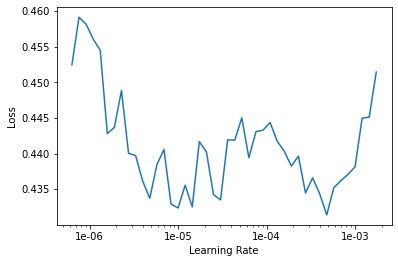

In [68]:
learn.recorder.plot()

In [69]:
learn.fit_one_cycle(10, slice(1e-3/1.5), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.365318,0.317812,0.911471,03:07
1,0.349730,0.334278,0.902739,03:06
2,0.353561,0.301886,0.917811,03:06
3,0.372390,0.340013,0.906035,03:06
4,0.369981,0.335112,0.910802,03:06
5,0.358304,0.358669,0.905333,03:06
6,0.385222,0.381912,0.904585,03:06
7,0.367095,0.326605,0.917043,03:06
8,0.311890,0.268491,0.927750,03:06
9,0.249566,0.256983,0.928599,03:07


Improved Accuracy = 92.8% which is equivalent to the state of the art results achieved so far on the camvid dataset

In [70]:
learn.save('BIG-1')

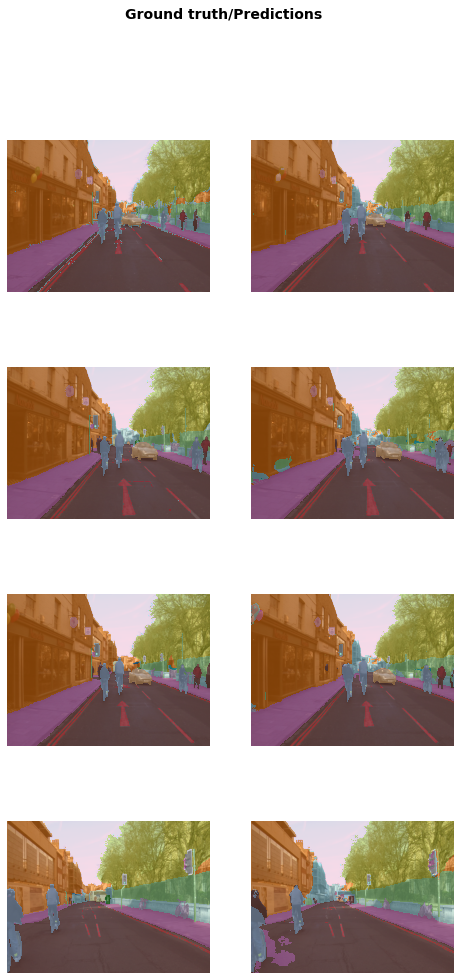

In [71]:
learn.show_results()